<a href="https://colab.research.google.com/github/alaaasfour/Fake-News-Detection/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Packages and Read the data**

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

Mount Google Drive to access the dataset and Load the fake and real news datasets

In [ ]:
drive.mount('/content/drive')
fake_data = pd.read_csv('/content/drive/My Drive/Projects/datasets/fake-real-data/Fake.csv')
real_data = pd.read_csv('/content/drive/My Drive/Projects/datasets/fake-real-data/True.csv')

Mounted at /content/drive


Assign labels (0 = Fake, 1 = Real)

In [ ]:
fake_data['label'] = 0
real_data['label'] = 1

Drop nulls and duplicates to clean the data

In [ ]:
fake_data.dropna(inplace=True)
fake_data.drop_duplicates(inplace=True)
real_data.dropna(inplace=True)
real_data.drop_duplicates(inplace=True)

Merge title and text fields into a single content column

In [ ]:
fake_data['content'] = fake_data['title'] + ' ' + fake_data['text']
real_data['content'] = real_data['title'] + ' ' + real_data['text']

Text cleaning: lowercasing, removing non-alphabetic chars, stemming, and removing stopwords

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

fake_data['clean_content'] = fake_data['content'].apply(clean_text)
real_data['clean_content'] = real_data['content'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Text Vectorization (Feature Extraction)

Feature extraction using TF-IDF vectorizer

In [ ]:
# Option 1: TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
fake_tfidf = vectorizer.fit_transform(fake_data['clean_content'])
real_tfidf = vectorizer.transform(real_data['clean_content'])

Split data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(fake_tfidf, fake_data['label'], test_size=0.2, random_state=42)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(real_tfidf, real_data['label'], test_size=0.2, random_state=42)

Train multiple classical ML models and compare performance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from scipy.sparse import vstack

# Combine fake and real data
X_combined = vstack([fake_tfidf, real_tfidf])
y_combined = pd.concat([fake_data['label'], real_data['label']])

# Split combined data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} Accuracy: {model.score(X_test, y_test)}")

Random Forest Accuracy: 0.9978742447974939
Logistic Regression Accuracy: 0.9931752069814276
Naive Bayes Accuracy: 0.9346609979861267


Evaluate the final model using classification metrics

In [ ]:
# Using metrics such as accuracy, precision, recall, F1-score
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4738
           1       0.92      0.94      0.93      4200

    accuracy                           0.93      8938
   macro avg       0.93      0.94      0.93      8938
weighted avg       0.93      0.93      0.93      8938

[[4398  340]
 [ 244 3956]]


Visualize the confusion matrix

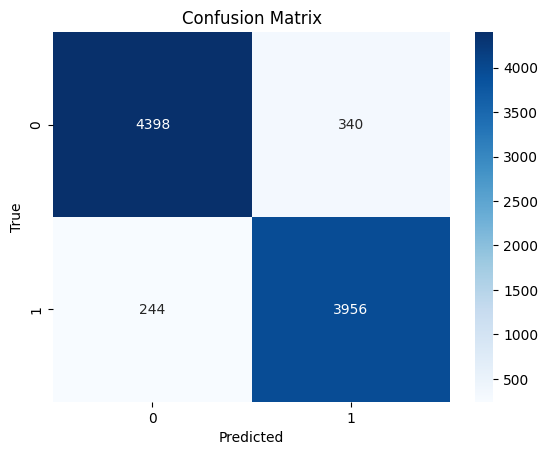

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Prepare data for BERT fine-tuning

In [ ]:
df = pd.concat([fake_data, real_data])
X_text = df['clean_content'].values
y = df['label'].values

from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(X_train_text), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test_text), truncation=True, padding=True, max_length=128)

Load pre-trained BERT model for sequence classification

In [ ]:
from transformers import TFBertForSequenceClassification
from transformers import create_optimizer
import tensorflow as tf

# Create the BERT model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set BERT training parameters
batch_size = 16
num_epochs = 3
steps_per_epoch = len(X_train_text) // batch_size
num_train_steps = steps_per_epoch * num_epochs
num_warmup_steps = int(0.1 * num_train_steps)

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=num_warmup_steps,
    num_train_steps=num_train_steps
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compile BERT model
bert_model.compile(optimizer=optimizer,
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

# Convert labels and create TensorFlow Datasets
y_train = tf.convert_to_tensor(y_train, dtype=tf.int64)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int64)

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(batch_size)

In [ ]:
# Fine-tune the BERT model
bert_model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/3
2235/2235 [==============================] - 1552s 664ms/step - loss: 0.0606 - accuracy: 0.9759 - val_loss: 0.0131 - val_accuracy: 0.9971
Epoch 2/3
2235/2235 [==============================] - 1485s 665ms/step - loss: 0.0069 - accuracy: 0.9985 - val_loss: 0.0064 - val_accuracy: 0.9985
Epoch 3/3
2235/2235 [==============================] - 1481s 663ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0045 - val_accuracy: 0.9989


Save the fine-tuned BERT model and tokenizer

In [ ]:
bert_model.save_pretrained("/content/drive/My Drive/Projects/pretrained_models/bert-fake-news-model")
tokenizer.save_pretrained("/content/drive/My Drive/Projects/pretrained_models/bert-fake-news-model")

('/content/drive/My Drive/Projects/pretrained_models/bert-fake-news-model/tokenizer_config.json',
 '/content/drive/My Drive/Projects/pretrained_models/bert-fake-news-model/special_tokens_map.json',
 '/content/drive/My Drive/Projects/pretrained_models/bert-fake-news-model/vocab.txt',
 '/content/drive/My Drive/Projects/pretrained_models/bert-fake-news-model/added_tokens.json')